In [2]:
import json
import numpy as np
import pandas as pd

from keras import regularizers
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Activation
from keras.layers import Dropout
from keras.layers import Flatten
from keras.optimizers import Adam
import tensorflow as tf
from datetime import datetime 
import shap
import matplotlib
from matplotlib import cm
import plotly.graph_objects as go
import plotly.express as px
from keras import backend as K

from sklearn.metrics import mean_squared_error as mse

import warnings
warnings.filterwarnings('ignore')

In [3]:
## Some helper functions
def map2layer(x, layer):
    feed_dict = dict(zip([model.layers[0].input], [x.copy()]))
    return K.get_session().run(model.layers[layer].input, feed_dict)

def matplotlib_to_plotly(cmap, pl_entries):
    h = 1.0/(pl_entries-1)
    pl_colorscale = []

    for k in range(pl_entries):
        C = list(map(np.uint8, np.array(cmap(k*h)[:3])*255))
        pl_colorscale.append([k*h, 'rgb'+str((C[0], C[1], C[2]))])
    return pl_colorscale


# Create random data with numpy

def plotly_LSTM_with_outliers(data, error_index_list, time_steps=20):
    fig = go.Figure()
    x_axis = np.linspace(1, time_steps, time_steps)
    for i in range(len(data)):
        data_i = data[i]
        if i in error_index_list:
            fig.add_trace(go.Scatter(x=x_axis, y=data_i,
                        mode='lines',
                        name=i, line=dict(color='red', width=1)))
        else:
            fig.add_trace(go.Scatter(x=x_axis, y=data_i,
                        mode='lines',
                        name=i, line=dict(color='black', width=1)))

    fig.show()
    
    
## some colors
coolwarm_cmap = matplotlib.cm.get_cmap('coolwarm')
coolwarm = matplotlib_to_plotly(coolwarm_cmap, 255)

magma_cmap = matplotlib.cm.get_cmap('magma')
magma = matplotlib_to_plotly(magma_cmap, 255)

In [4]:
# HPCCv1 data
variables_name = pd.read_csv("../data/variables_name.csv", header=None)
features = variables_name.values[:,1]


with open("../data/X_train_HPCC_1_20_312.json") as of:
    X_train = np.array(json.load(of))
with open("../data/y_train_HPCC_1_20_312.json") as of:
    y_train = np.array(json.load(of))
with open("../data/X_test_HPCC_1_20_312.json") as of:
    X_test = np.array(json.load(of))
with open("../data/y_test_HPCC_1_20_312.json") as of:
    y_test = np.array(json.load(of))    

In [5]:
## Sort data by target
train_sorted_index = np.argsort(y_train)
X_train = X_train[train_sorted_index]
y_train = sorted(y_train)

In [6]:
# Recreate the exact same model, including its weights and the optimizer
model = tf.keras.models.load_model('../dump_model/model.h5')

# Show the model architecture
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 20, 8)             608       
_________________________________________________________________
lstm_2 (LSTM)                (None, 20, 8)             544       
_________________________________________________________________
flatten_1 (Flatten)          (None, 160)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 8)                 1288      
_________________________________________________________________
dense_2 (Dense)              (None, 4)                 36        
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 5         
Total params: 2,481
Trainable params: 2,481
Non-trainable params: 0
____________________________________________________

In [12]:
explainer = shap.DeepExplainer(model, X_train)
shap_values_train = explainer.shap_values(X_train)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


# SHAP for ALL Instances

In [13]:
################# Plot AVERAGE shap values for ALL observations  #####################
## Consider ABSOLUTE of SHAP values ##
shap.initjs()
shap_average_abs_value_train = np.abs(shap_values_train[0]).mean(axis=0)

x_average_value_train = pd.DataFrame(data=X_train.mean(axis=0), columns = features)
shap.force_plot(0, shap_average_abs_value_train, x_average_value_train)

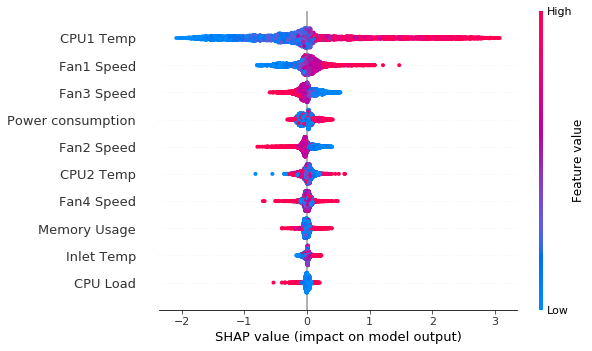

In [14]:
shap_values_train_2D = shap_values_train[0].reshape(-1,10)
X_train_2D = X_train.reshape(-1,10)

shap.summary_plot(shap_values_train_2D, X_train_2D, features)

# Explain for each instance (input layer)

CPU1 Temp
(312, 20)


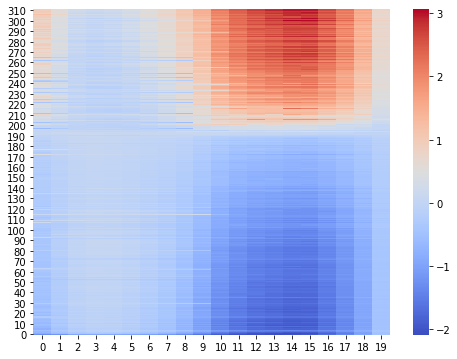

-----------
CPU2 Temp
(312, 20)


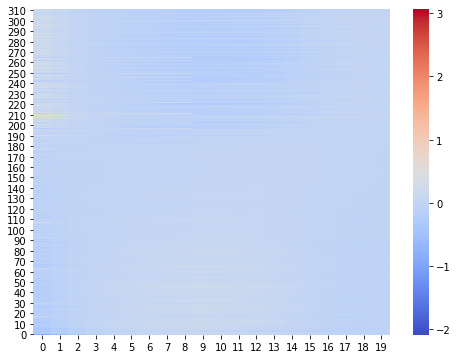

-----------
Inlet Temp
(312, 20)


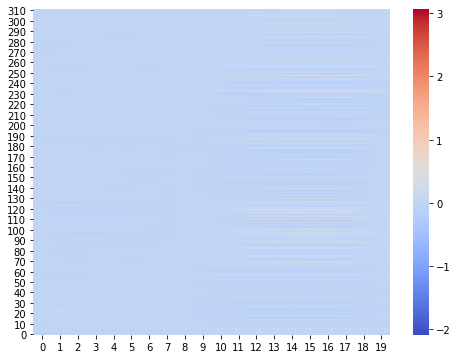

-----------
CPU Load
(312, 20)


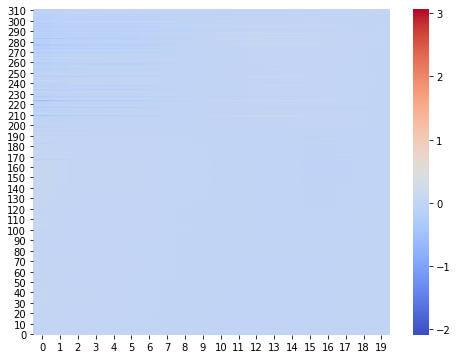

-----------
Memory Usage
(312, 20)


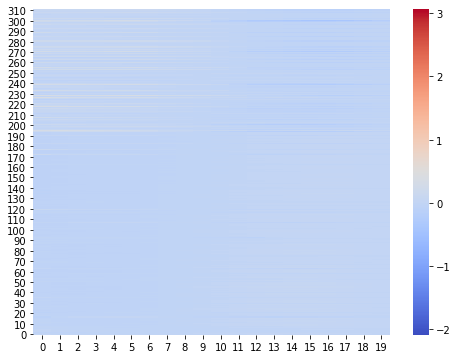

-----------
Fan1 Speed
(312, 20)


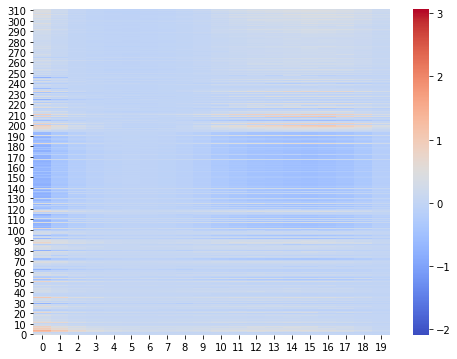

-----------
Fan2 Speed
(312, 20)


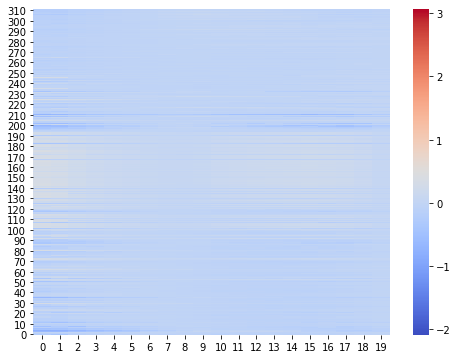

-----------
Fan3 Speed
(312, 20)


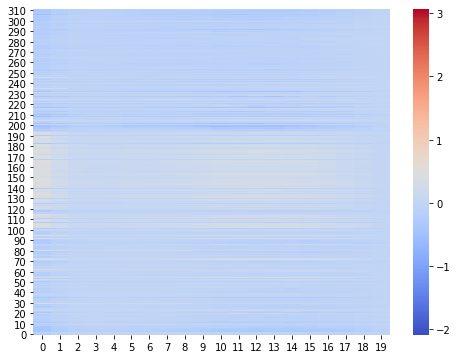

-----------
Fan4 Speed
(312, 20)


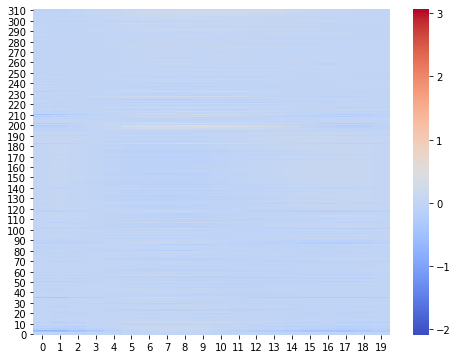

-----------
Power consumption
(312, 20)


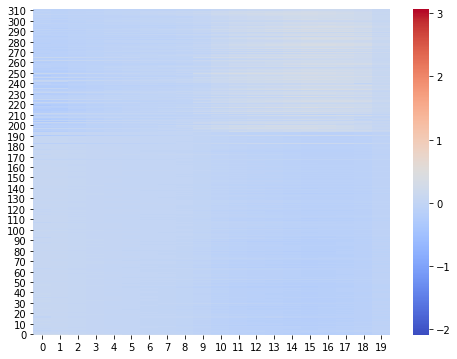

-----------


In [28]:
import seaborn as sns
import matplotlib.pyplot as plt

vmin, vmax = shap_values_train[0].min(), shap_values_train[0].max()

for i, feature in enumerate(features):
    print(feature)

    plt.figure(figsize = (8,6)) 
    tmp = shap_values_train[0][:,:,i].reshape((-1,20))
    print(tmp.shape)
    plot_shap = sns.heatmap(tmp, cmap="coolwarm", vmin= vmin, vmax=vmax, )
    plot_shap.invert_yaxis()
    plt.show(plot_shap)
    print("-----------")

Some Comments

- CPU1 Temp: Light color at early time steps. It starts bolder from 10th to 18th steps => These steps play an important role in prediction. (recall that output is the sum of 20*10 importance scores)
- Other features seem contribute slightly on the output.

In [16]:
## Print layers'shape
from keras import backend as K

inp = model.input                                           # input placeholder
outputs = [layer.output for layer in model.layers]          # all layer outputs
functors = [K.function([inp], [out]) for out in outputs]    # evaluation functions

# Testing
layer_outs = [func([X_train]) for func in functors]

for i in range(len(layer_outs)):
    print(layer_outs[i][0].shape)


(312, 20, 8)
(312, 20, 8)
(312, 160)
(312, 8)
(312, 4)
(312, 1)


# Explain for LSTM layers

===== Layer 1 =====
shap values shape = (312, 20, 8)
Node 1
(312, 20)


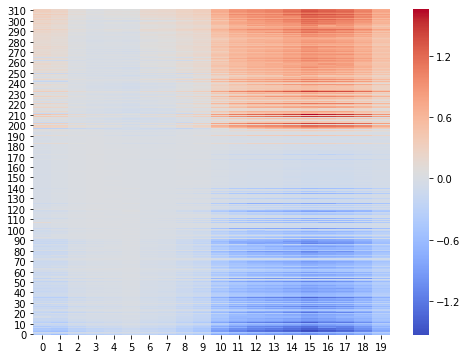

-----------
Node 2
(312, 20)


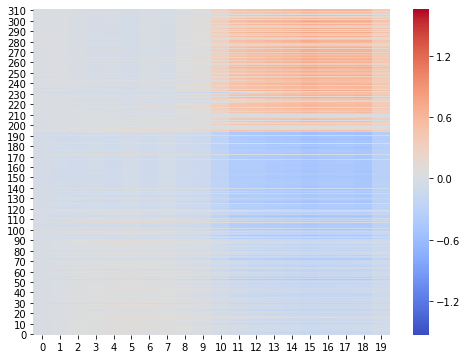

-----------
Node 3
(312, 20)


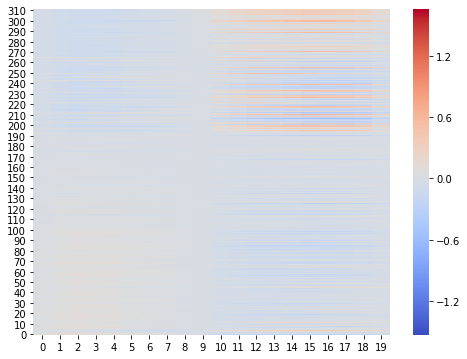

-----------
Node 4
(312, 20)


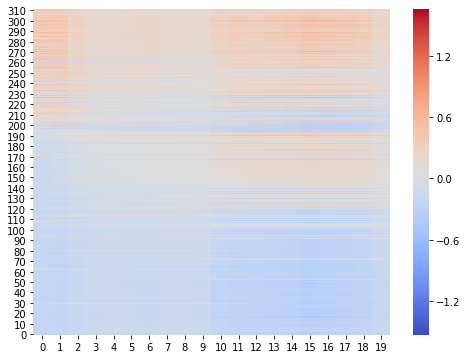

-----------
Node 5
(312, 20)


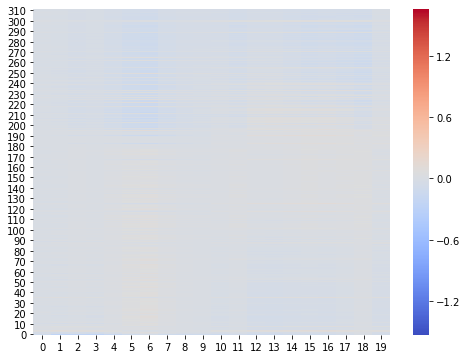

-----------
Node 6
(312, 20)


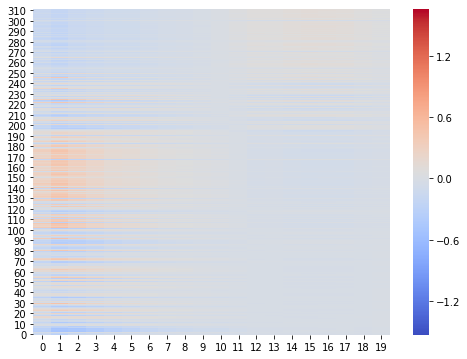

-----------
Node 7
(312, 20)


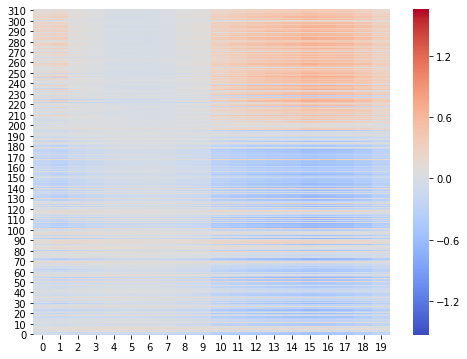

-----------
Node 8
(312, 20)


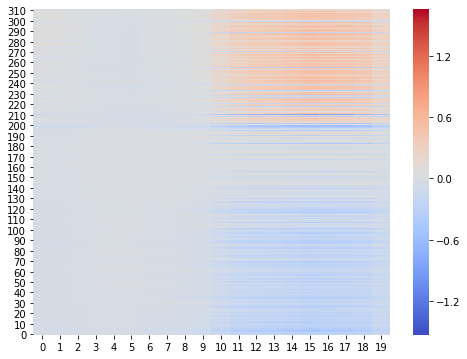

-----------
-----------------------


===== Layer 2 =====
shap values shape = (312, 20, 8)
Node 1
(312, 20)


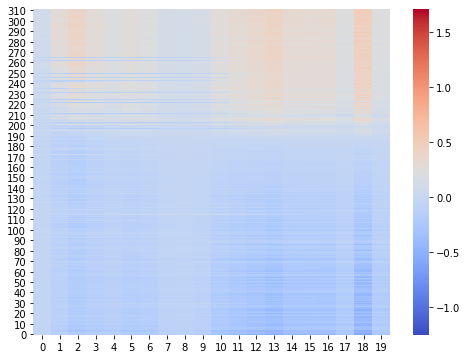

-----------
Node 2
(312, 20)


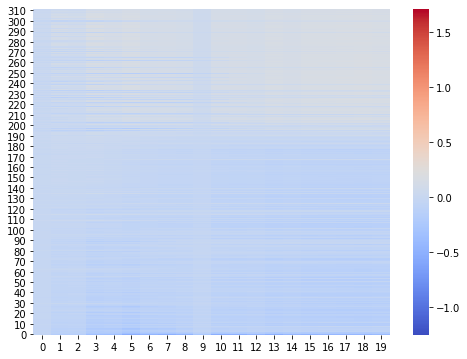

-----------
Node 3
(312, 20)


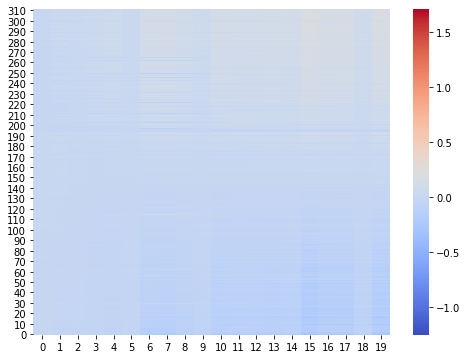

-----------
Node 4
(312, 20)


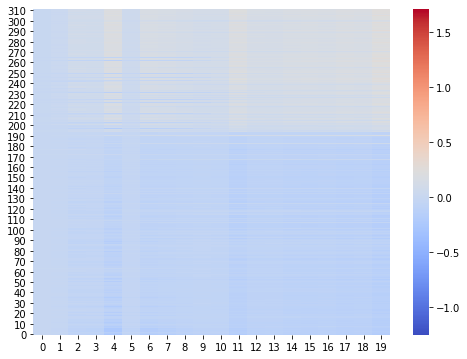

-----------
Node 5
(312, 20)


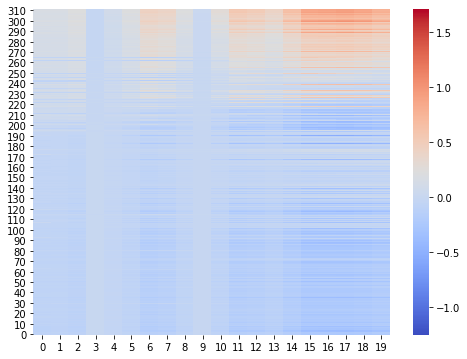

-----------
Node 6
(312, 20)


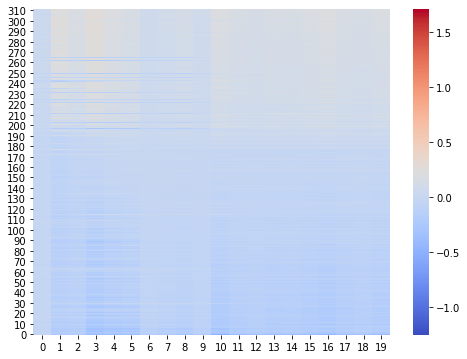

-----------
Node 7
(312, 20)


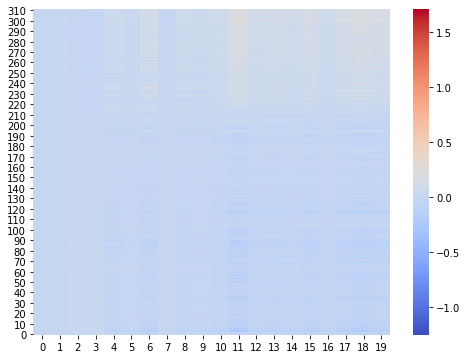

-----------
Node 8
(312, 20)


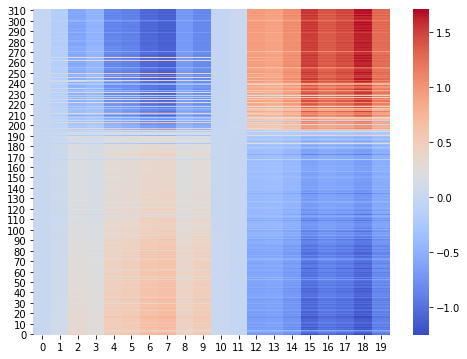

-----------
-----------------------




In [29]:
# explain how the input to the ith layer of the model explains the prediction

for i in range(1, 3):
    layer = i
    e = shap.DeepExplainer((model.layers[layer].input, model.layers[-1].output), map2layer(X_train.copy(), layer), )
    shap_values_i, indexes = e.shap_values(map2layer(X_train, layer), ranked_outputs = 1)
    
    vmin, vmax = shap_values_i[0].min(), shap_values_i[0].max()
    print("====================")
    print("===== Layer {} =====".format(i))
    print("shap values shape =", shap_values_i[0].shape)
    for j in range(shap_values_i[0].shape[-1]):
        print("Node {}".format(j+1))
        plt.figure(figsize = (8,6)) 
        tmp = shap_values_i[0][:,:,j].reshape((-1,20))
        print(tmp.shape)
        plot_shap = sns.heatmap(tmp, cmap="coolwarm", vmin= vmin, vmax=vmax)
        plot_shap.invert_yaxis()

        plt.show(plot_shap)
        print("-----------")
    print("-----------------------\n\n") 

# Explain for Dense Layers

====== Layer 4 =====
shap values shape = (312, 8)
Node 1


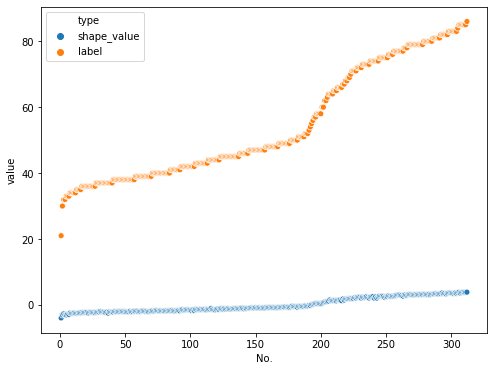

-----------------------


Node 2


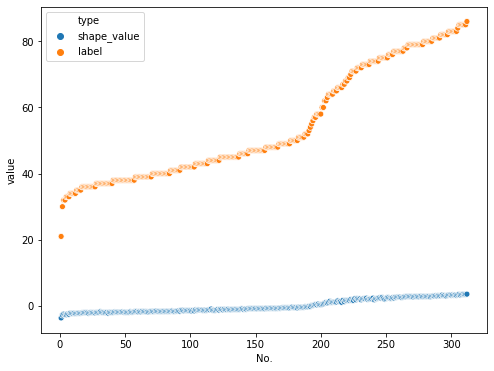

-----------------------


Node 3


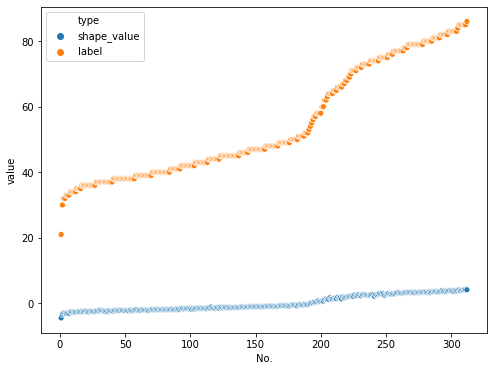

-----------------------


Node 4


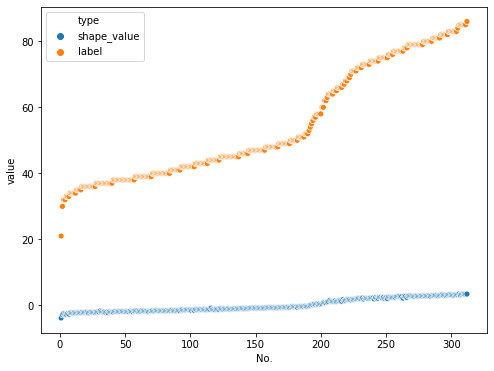

-----------------------


Node 5


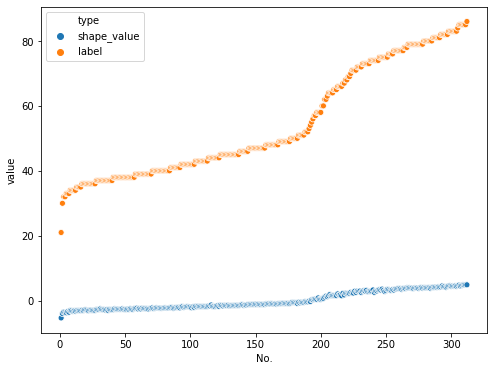

-----------------------


Node 6


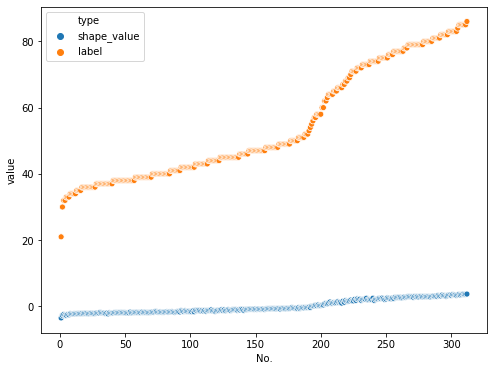

-----------------------


Node 7


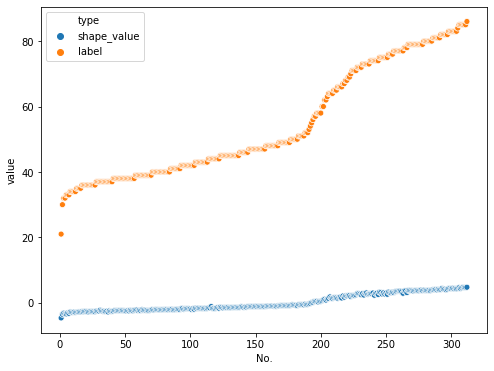

-----------------------


Node 8


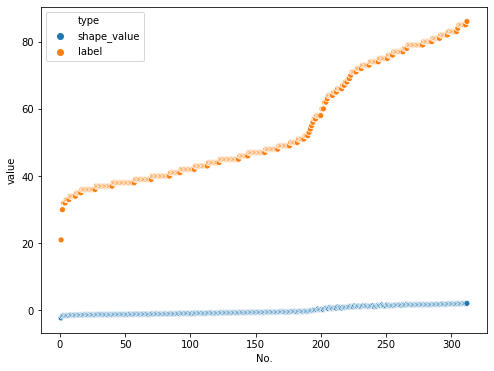

-----------------------


====== Layer 5 =====
shap values shape = (312, 4)
Node 1


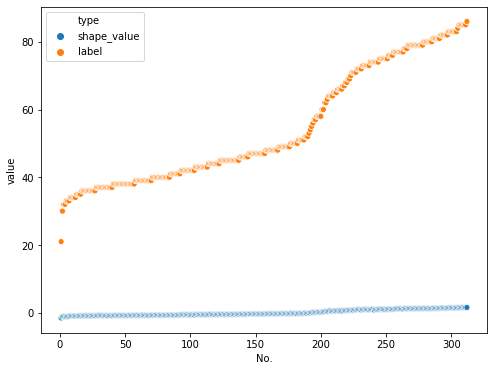

-----------------------


Node 2


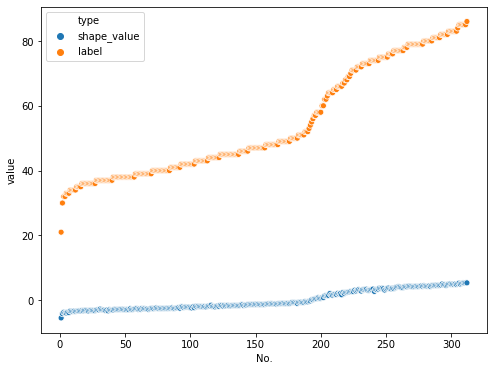

-----------------------


Node 3


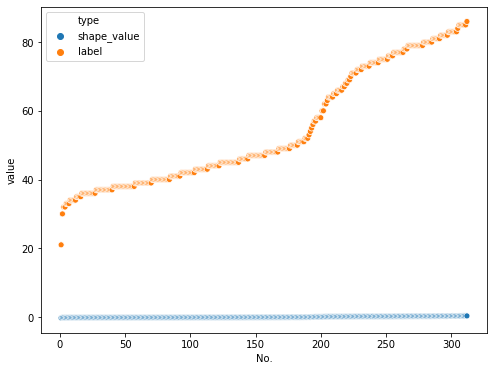

-----------------------


Node 4


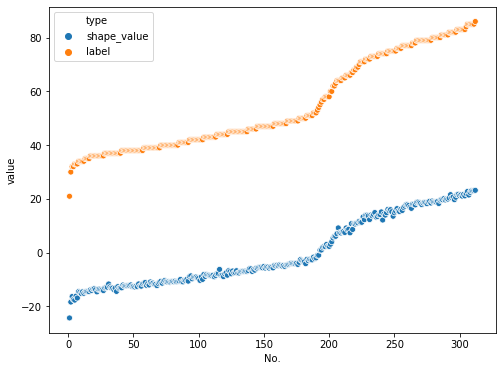

-----------------------




In [18]:
for i in range(4,len(layer_outs)):
    layer = i
    e = shap.DeepExplainer((model.layers[layer].input, model.layers[-1].output), map2layer(X_train.copy(), layer), )
    shap_values_i, indexes = e.shap_values(map2layer(X_train, layer), ranked_outputs = 1)
    shap_values_i[0].shape

    print("====================")
    print("====== Layer {} =====".format(i))
    print("shap values shape =", shap_values_i[0].shape)
    for j in range(shap_values_i[0].shape[-1]):
        print("Node {}".format(j+1))
        
        plt.figure(figsize = (8,6)) 
        tmp = shap_values_i[0][:,j].reshape(len(X_train))
        tmp_df = pd.DataFrame(data=[tmp, y_train])
        tmp_df = tmp_df.transpose()
        tmp_df.columns = ["shap_value", "label"]
#         tmp_df.sort_values("label", inplace=True)
        tmp_df["No."] = range(1, len(tmp_df)+1)

        tmp_1 = tmp_df[["shap_value", "No."]].copy()
        tmp_2 = tmp_df[["label", "No."]].copy()

        tmp_1.columns = ["value", "No."]
        tmp_1["type"] = "shape_value"
        tmp_2.columns = ["value", "No."]
        tmp_2["type"] = "label"

        tmp_full = pd.concat([tmp_1, tmp_2])
        
        plot_shap = sns.scatterplot(x="No.", y="value", data=tmp_full, hue="type")
        plt.show(plot_shap)
        print("-----------------------\n\n") 

# Prediction vs Label on Train set

In [9]:
y_pred = model.predict(X_train)
y_pred_test = model.predict(X_test)

tmp_df = pd.DataFrame(data=[y_pred[:,0], y_train])
tmp_df = tmp_df.transpose()
tmp_df.columns = ["prediction", "label"]
tmp_df["No."] = range(1, len(tmp_df)+1)

tmp_df["error (%)"] = np.round (np.abs((tmp_df.label - tmp_df.prediction)*100/tmp_df.label), 2)
tmp_df

prediction  label  No.  error (%)
0     23.057285   21.0    1       9.80
1     30.703455   30.0    2       2.34
2     33.344128   32.0    3       4.20
3     31.971138   32.0    4       0.09
4     31.681570   33.0    5       4.00
..          ...    ...  ...        ...
307   84.040916   85.0  308       1.13
308   84.823898   85.0  309       0.21
309   84.703949   85.0  310       0.35
310   84.885674   85.0  311       0.13
311   85.050690   86.0  312       1.10

[312 rows x 4 columns]

In [10]:
print("Error on Traing set:", mse(y_train, y_pred))
print("Error on Test set:", mse(y_test, y_pred_test))

Error on Traing set: 0.5720518208567088
Error on Test set: 1.6908512994541998


In [20]:
tmp_df["error (%)"].describe([i*.05 for i in range(20)] + [.97,.98,.985,.99])

count    312.000000
mean       1.197788
std        1.115569
min        0.010000
0%         0.010000
5%         0.110000
10%        0.181000
15%        0.246500
20%        0.340000
25%        0.437500
30%        0.553000
35%        0.648500
40%        0.734000
45%        0.829500
50%        0.950000
55%        1.100000
60%        1.172000
65%        1.273000
70%        1.417000
75%        1.582500
80%        1.810000
85%        2.053500
90%        2.418000
95%        3.037000
97%        3.980200
98%        4.178000
98.5%      4.723600
99%        4.999100
max        9.800000
Name: error (%), dtype: float64

In [21]:
tmp_1 = tmp_df[["prediction", "No.", "error (%)"]].copy()
tmp_2 = tmp_df[["label", "No.", "error (%)"]].copy()

tmp_1.columns = ["value", "No.", "error (%)"]
tmp_1["type"] = "prediction"
tmp_2.columns = ["value", "No.", "error (%)"]
tmp_2["type"] = "label"

tmp_full = pd.concat([tmp_1, tmp_2])

In [22]:
error_thres = 3

In [23]:
fig = px.scatter(tmp_full, x="No.", y="value", color="type",
                 size='error (%)', hover_data=['error (%)'], opacity=0.6,  
                 color_discrete_map = {"prediction": "blue", "label": "black"})
fig.show()

In [24]:
tmp_full["type"]  = tmp_full.apply(lambda x: "big error" if ((x['error (%)'] > error_thres) & (x['type'] == 'prediction')) else x["type"], 1)
fig = px.scatter(tmp_full, x="No.", y="value", color="type",
                 hover_data=['error (%)'], opacity=0.4,
                 color_discrete_map = {"prediction": "blue", "label": "black", "big error": "red"})
fig.show()

In [25]:
tmp_full.to_csv("./prediction.csv")
tmp_full

value  No.  error (%)        type
0    23.057285    1       9.80   big error
1    30.703455    2       2.34  prediction
2    33.344128    3       4.20   big error
3    31.971138    4       0.09  prediction
4    31.681570    5       4.00   big error
..         ...  ...        ...         ...
307  85.000000  308       1.13       label
308  85.000000  309       0.21       label
309  85.000000  310       0.35       label
310  85.000000  311       0.13       label
311  86.000000  312       1.10       label

[624 rows x 4 columns]

In [26]:
# tmp_full  = pd.read_csv("./prediction.csv")

In [27]:
error_index_list= list(tmp_full[tmp_full.type == "big error"].index)

# Show outliers

## Input

In [ ]:
for i, feature in enumerate(features):
    print(feature)

    plt.figure(figsize = (8,6)) 
    tmp = shap_values_train[0][:,:,i].reshape((-1,20))
    print(tmp.shape)
    plotly_LSTM_with_outliers(tmp, error_index_list)
    print("-----------")

## LSTM

In [ ]:
for i in range(1, 3):
    layer = i
    e = shap.DeepExplainer((model.layers[layer].input, model.layers[-1].output), map2layer(X_train.copy(), layer), )
    shap_values_i, indexes = e.shap_values(map2layer(X_train, layer), ranked_outputs = 1)
    
    print("====================")
    print("===== Layer {} =====".format(i))
    print("shap values shape =", shap_values_i[0].shape)
    for j in range(shap_values_i[0].shape[-1]):
        print("Node {}".format(j+1))
        plt.figure(figsize = (8,6)) 
        tmp = shap_values_i[0][:,:,j].reshape((-1,20))
        print(tmp.shape)
        plotly_LSTM_with_outliers(tmp, error_index_list)
        print("-----------")
    print("-----------------------\n\n") 

## Dense

In [ ]:
for i in range(4,len(layer_outs)):
    layer = i
    e = shap.DeepExplainer((model.layers[layer].input, model.layers[-1].output), map2layer(X_train.copy(), layer), )
    shap_values_i, indexes = e.shap_values(map2layer(X_train, layer), ranked_outputs = 1)
    shap_values_i[0].shape

    print("====================")
    print("====== Layer {} =====".format(i))
    print("shap values shape =", shap_values_i[0].shape)
    for j in range(shap_values_i[0].shape[-1]):
        print("Node {}".format(j+1))
        
        
        tmp = shap_values_i[0][:,j].reshape(len(X_train))
        tmp_df = pd.DataFrame(data=[tmp, y_train])
        tmp_df = tmp_df.transpose()
        tmp_df.columns = ["shap_value", "label"]
#         tmp_df.sort_values("label", inplace=True)
        tmp_df["No."] = range(1, len(tmp_df)+1)


        tmp_1 = tmp_df[["shap_value", "No."]].copy()
        tmp_2 = tmp_df[["label", "No."]].copy()

        tmp_1.columns = ["value", "No."]
        tmp_1["type"] = "shap_value"
        tmp_2.columns = ["value", "No."]
        tmp_2["type"] = "label"

        tmp_1.loc[error_index_list, "type"]  = "big error"
        tmp_full = pd.concat([tmp_1, tmp_2])

        fig = px.scatter(tmp_full, x="No.", y="value", color="type",
                  opacity=0.6,
                 color_discrete_map = {"shap_value": "blue", "label": "black", "big error": "red"})
        fig.show()

        print("-----------------------\n\n") 

In [ ]:
print("Last updated: ", datetime.now())